# Titanic Survival Prediction

## Table of Contents
1 [Project Summary](#summary)  
2 [Loading](#loading)  
2.1 [Import Libraries](#libraries)  
2.2 [Import Data](#data)  
2.3 [Functions](#function)  
3 [Exploring the data](#eda)  
3.1 [Data Overview](#overview)  
3.1.1 [Input Variables](#input)  
3.1.2 [Profile](#profile)  
3.2 [Data Cleaning](#cleaning)  
3.3 [Visualisation](#visualisation)  
3.4 [Feature Engineering](#feature)  
3.5 [Preprocessing](#preprocess)  
4 [Model Deployment](#modeldep)  
4.1 [ Model Development / Model Tuning / Model Validation](#developmodel)  
<!-- 4.2 [Model Tuning](#modeltune)
4.3 [Model Validation](#validate)   -->
5 [Deploy](#deploy)  
[Appendix](#Append)

# Project Summary
<a id="summary"></a>
***
**Situation**  
Titanic sank after colliding with an iceberg on 15th April 1912, resulting in the death of 1502 out of 2224 passengers and crew. Although there was a luck element to survive in this incident, it seems that some groups of people were more likely to survive than others. This project aims to find key elements related to survived groups and predict who can survive in the Titanic shipwreck.  
  
**Action and Goal**  
Using the passenger data provided from Kaggle, exploratory data analysis (EDA) and model deployment are implemented by using Python and jupyter notebook. The goal is to build a predictive model that answers the question: what kind of people/groups is more likely to survive?  Since the output from the model is expected to be binary (1:survived or 0:not survived), a binary model is needed to be built by exploring classification algorithms such as decision tree, random forest, support vector machine (SVM) and a neural network. The deployed model is evaluated by cross-validation and the result from the model is submitted to the Kaggle leaderboard.

# Loading
<a id="loading"></a>

## Import Libraries
<a id="libraries"></a>
***
These libraries can be installed from **Pipfile** and **Pipfile.lock** using pipenv (**Python version: 3.7.5**)

In [1]:
# ----------------------- Libraries required -----------------------
import sys, os
sys.path.append(os.pardir)
import math 
import warnings
warnings.filterwarnings('ignore')

# EDA / Data engineering
import numpy as np
import pandas as pd
import pandas_profiling as pdp

from sklearn import preprocessing

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default='iframe'

# Model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import ExtraTreesClassifier as ETC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
# from keras.backend import tensorflow_backend as backend

from xgboost import XGBClassifier as XGB
import lightgbm as LGB

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline, Pipeline

# Validation/Model tuning
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

## Import Data
<a id="data"></a>
***
**Files in "data" directory:**  
  
- train.csv: training set

- test.csv: test set

(https://www.kaggle.com/c/titanic/data)

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

In [3]:
# Create df_full by concatenating df_train and df_test
df_test["Survived"] = np.nan
df_full = pd.concat([df_train, df_test], axis=0)
# df_full

## Functions
<a id="function"></a>
This section defines some custom-made functions to be used in [EDA](#eda), [Visualisation](#visualisation) and [Model deployment](#modeldep).

***
***
**Data Profile**
***
This function provides a summary of data structure in dataframe such as data types, count of the null data and count of the unique values. (See [Profile](#profile))

In [4]:
def data_profile(df):
    
    # Datatype
    df_dtype = pd.DataFrame(df.dtypes)
    
    # Null count
    df_null = pd.DataFrame(df.isnull().sum())
    # Null ratio (%)
    null_ratio = df.isnull().sum() / df.shape[0] * 100 #Percentage
    null_ratio = null_ratio.apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    df_null_ratio = pd.DataFrame(null_ratio)
    
    # Non-null count
    df_notnull = pd.DataFrame(df.notnull().sum())
    
    # Unique value/Unique ratio(%)
    df_unique = {}
    df_unique_ratio = {}
    
    for column in df.columns:
        df_unique[column] = len(df[column].value_counts())
        df_unique_ratio[column] = len(df[column].value_counts()) / df.shape[0] *100 #Percentage
        
    df_unique = pd.DataFrame.from_dict(df_unique, orient='index')
    df_unique_ratio = pd.DataFrame.from_dict(df_unique_ratio, orient='index')
    df_unique_ratio = df_unique_ratio[0].apply(lambda x: math.floor(x * 10**2) / 10**2) #rounding
    
    # Create a new dataframe showing the data profile 
    df_profile = pd.concat([df_dtype, df_null, df_null_ratio, df_notnull, df_unique, df_unique_ratio], axis=1).reset_index()
    df_profile.columns = ['Column', 'Data type', 'Null count', 'Null ratio (%)', 'Non-null count', 'Distinct', 'Distinct (%)']
    
    num_dup = df.duplicated().sum()
    if num_dup > 0:
        print(str(num_dup) + 'rows are duplicated')
    else: print('No duplicated row')
    return df_profile

***
***
**Get summry statistics of grouped data**
***
This function generates a dataframe as dictionary that contains summary statistics of grouped data.(See [](#))  
Also, see examples in [Appendix](#Append) A1.

In [5]:
def grouped_data_summary(df, group_by ,group_key, agg_functions, new_col_names):
    ''' Get summary statistics of grouped data
    
    Parameters
    ----------
    df (dataframe):
    group_by (list): 
    key (list): 
    agg_function: aggregation functions (sum, mean, max, min,...)
    
    Return
    ----------
    df_dict - modified dataframe in dictionary format
    '''
    
    # Create a dictinary
    df_dict = {}
    
    for group_name in group_by:
        # get the data based on group
        df_modi = (
            df.groupby(group_name)[group_key]
            .agg(agg_functions)
        )
        
        # Rename column names
        df_modi.columns = new_col_names
        
        # Reset index
        df_modi = df_modi.reset_index()
        
        # Store the results in the dictonary
        df_dict[group_name] = df_modi
    
    return df_dict

***
***
**Barplots**
***
***barplot_plt()*** generates bar chart(s) using ***matplotlib*** on a single plot or multiple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [6]:
def barplot_plt(df, x_cols, y_col, plot_ax=0, fig_unit_size=[20,10]):
    """ Bar chart generated by matplotlib
    This plot can show on a single plot OR multi panel plots
    
    Parameters
    ----------
    df (dataframe in dictionary): 
    x_cols (list OR string): column names to plot on figures
    y_col (string): ex) 'a' 
    plot_ax(0 or 1, Default:0): 0: horizontal plots, 1: vertical plots
    fig_unit_size: figure size per one figure
    """
    import matplotlib.colors as mcolors
    # check the input type of x_cols
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_unit_size[0]*n_col, fig_unit_size[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_unit_size[0], fig_unit_size[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
        
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        x = df[key][key]
        y = df[key][y_col]
        axes.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
        axes.set_title(str(y_col) + " - " + str(key))
        axes.set_xlabel(key)
        axes.set_ylabel(y_col)
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            x = df[key][key]
            y = df[key][y_col]
            ax.bar(x, y, tick_label=x, color=mcolors.TABLEAU_COLORS)
            ax.set_title(str(y_col) + " - " + str(key))
            ax.set_xlabel(key)
            ax.set_ylabel(y_col)
        
    # show Figure
    plt.show()

***
***barplot_sns()*** generates bar chart(s) using ***seaborn*** on a single plot or multple plots. Dataframe must be dictionary format which is an output from ***groupby_summary()***

In [7]:
# Seaborn
def barplot_sns(df, x_cols, y_col, plot_ax=0, fig_unit_size=[20,10]):
    """ Bar chart generated by seaborn
    This plot can show on a single plot OR multi panel plots
    
    Parameters
    ----------
    df (dataframe in dictionary)
    x_cols (list OR string): column names to plot on figures
    y_col (string): ex) 'a' 
    plot_ax(0 or 1, Default:0): 0: horizontal plots, 1: vertical plots
    fig_unit_size: figure size per one figure
    """
    
    if  isinstance(x_cols, str):
        x_cols = [x_cols] #if the input is string, convert to list
    
    # Define figure size
    if plot_ax == 0:
        n_col = len(x_cols)
        n_row = 1
        fig_size = [fig_unit_size[0]*n_col, fig_unit_size[1]]
    
    elif plot_ax == 1:
        n_col = 1
        n_row = len(x_cols)
        fig_size = [fig_unit_size[0], fig_unit_size[1]*n_row]
        
    # Define subplot windows and axes
    fig, axes = plt.subplots(n_row, n_col, figsize=fig_size)
    plt.subplots_adjust(hspace=0.3)
    
    
    if len(x_cols) == 1: # single plot
        key = x_cols[0]
        
        sns.barplot(x=key, y=y_col, data=df[key]
                    , ax=axes, palette='Set1'
                   )
        
    else: # Multi plot
        for key, ax in zip(x_cols, axes):
            
            sns.barplot(x=key, y=y_col, data=df[key]
                        , ax=ax, palette='Set1'
                       )
    
    #Show plot
    plt.show()

***
***
**Model deployer**
***
This function deploy models with feature selection (SelectKBest(optional)) and parameter tuning (GridSearchCV(optional))

In [8]:
def model_deployer(models, X_train, y_train, X_test
                   , gs_params=None, select_num=None, cv=10):
    
    ''' Model deployer
    train models and return prediction results 
    
    Parameters
    ----------
    model (dictionary): a list of models used in prediction in dictionary 
    X_train (dataframe): training data
    y_train (dataframe): training label
    X_test (dataframe): test data to be predicted
    gs_params=None: a list of grid search parameters in dictionary (key must be the same as the key of the dictionary of the model)
    select_num=None: the number of features to be selected by SelectKBest
    cv=10: number of folding in cross-validation
    
    Return
    ------
    results (dictionary)
        -  'score': best score (GridSearchCV) or mean score (Cross-validation)
        -  'feature': used feature for model deployment
        -  'estimator': used estiamtor (best estiamtor in GridSearchCV)
        -  'feature_importances_': feaature importances (if available)
        -  'prediction': prediction results for test data
    '''
    
    from sklearn.feature_selection import SelectKBest
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay
    from sklearn.model_selection import KFold, cross_validate, cross_val_score
    from sklearn.model_selection import GridSearchCV
    results = {}
    
    if gs_params is None:
        gs_params = {k:None for k in models.keys()}
    
    for key in models.keys():
    # --- Feature Selection + GridSearchCV ---
        if (select_num is not None) and (gs_params[key] is not None):
            
            # Feature selection by SelectKBest
            select = SelectKBest(k=select_num)
            
            # Create pipline 
            pl = Pipeline([("Select", select), (key, models[key])])
            gs_params_key = gs_params[key].copy()

            # Change the key name of the dict to use the pipeline and GridSearch
            i = 0
            for k in gs_params_key.keys():
                i += 1
                if i > len(gs_params_key.keys()):
                    break
                else:
                    gs_params_key[key+'__'+ k] = gs_params_key.pop(k)
            # Show parameter name
#             print(gs_params_key.keys())
            
            # Grid Search CV
            gscv = GridSearchCV(estimator = pl
                                , param_grid=gs_params_key
                                , cv=cv
                                , refit=True # fit with the best paramerters
#                                 , verbose=2
                                , n_jobs=-1
                               )

            # train model
            gscv.fit(X_train, y_train)
            
            # Get used feature names
            mask = gscv.best_estimator_.named_steps["Select"].get_support()
            feature_name = X_train.columns[mask]
            
            # Show the results
            print(str(key) + "(with SelectKBest (k=" + str(select_num) + ") and GridSearchCV)")
            print("Best Score:{}".format(np.round(gscv.best_score_, 4))) # show the best score
            print("Best Prameters:", gscv.best_params_) # the best parameters in Grid Searchb
            print("----------------------------------")
            
            # Results
            if hasattr(gscv.best_estimator_.named_steps[key], 'feature_importances_'):
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':gscv.best_estimator_.named_steps[key].feature_importances_
                                , 'prediction':gscv.predict(X_test)
                                }
            else:
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':None
                                , 'prediction':gscv.predict(X_test)
                                }
            
      # --- Feature Selection ---      
        elif (select_num is not None) and (gs_params[key] is None): #Only SelectKBest
            # Feature selection by SelectKBest
            select = SelectKBest(k=select_num)
        
            # Create pipeline
            pl = Pipeline([("Select", select), (key, models[key])])
            # Train model
            pl.fit(X_train, y_train)
            
            # Cross validation
            cv_result = cross_validate(pl, X_train, y_train, cv=cv)
            
            # Get used feature names
            mask = select.get_support()
            feature_name = X_train.columns[mask]
            
             # Show the results
            print(str(key) + "(with SelectKBest (k=" + str(select_num) + "))")
            print("Mean Score:{}".format(np.round(np.mean(cv_result['test_score']), 4))) # show the mean score
            print("Mean std:{}".format(np.round(np.std(cv_result['test_score']), 4))) # Standard deviation of the score
            print("----------------------------------")
            
            if hasattr(pl.named_steps[key], 'feature_importances_'):
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator': models[key]
                                , 'feature_importances':pl.named_steps[key].feature_importances_
                                , 'prediction':pl.predict(X_test)
                                }
            else:
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator':models[key]
                                , 'feature_importances':None
                                , 'prediction':pl.predict(X_test)
                                }
       # ---  GridSearchCV --- 
        elif (select_num is None) and (gs_params[key] is not None): #Only GridSearchCV
            # Feature name used in model deployment
            feature_name = X_train.columns
            
            gs_params_key = gs_params[key].copy()

            # Show parameter name
#             print(gs_params_key.keys())
            # GridSearch CV 
            gscv = GridSearchCV(estimator = models[key]
                                , param_grid=gs_params_key#gs_params[key]
                                , cv=cv
                                , refit=True # fit with the best paramerters
#                                 , verbose=2
                                , n_jobs=-1
                               )
            # train model
            gscv.fit(X_train, y_train)
            
            # Show the results
            print(str(key) + "(with GridSearchCV)")
            print("Best Score:{}".format(np.round(gscv.best_score_, 4))) # show the best score
            print("Best Prameters:", gscv.best_params_) # the best parameters in Grid Searchb
            print("----------------------------------")
            # Results
            if hasattr(gscv.best_estimator_, 'feature_importances_'):
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':gscv.best_estimator_.feature_importances_
                                , 'prediction':gscv.predict(X_test)
                                }
            else:
                results[key] = {'score': gscv.best_score_
                                , 'feature_name': feature_name
                                , 'estimator':gscv.best_estimator_
                                , 'feature_importances':None
                                , 'prediction':gscv.predict(X_test)
                                }
        else: #just models
            
            # Feature name used in model deployment
            feature_name = X_train.columns
            
            # Model
            clf = models[key]
            
            # train model
            clf.fit(X_train, y_train)
            
            # Cross validation
            cv_result = cross_validate(clf, X_train, y_train, cv=cv)
            
            # Show the results
            print(str(key))
            print("Mean Score:{}".format(np.round(np.mean(cv_result['test_score']), 4))) # show the mean score
            print("Mean std:{}".format(np.round(np.std(cv_result['test_score']), 4))) # Standard deviation of the score
            print("----------------------------------")

            if hasattr(clf, 'feature_importances_'):
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator': models[key]
                                , 'feature_importances':clf.feature_importances_
                                , 'prediction':clf.predict(X_test)
                                }
            else:
                results[key] = {'score': np.mean(cv_result['test_score'])
                                , 'feature_name': feature_name
                                , 'estimator':models[key]
                                , 'feature_importances':None
                                , 'prediction':clf.predict(X_test)
                                }
    return results
        

***
***
# Exploring the Data
<a id="eda"></a>
***
***

## Data Overview
<a id="overview"></a>
***  

### Input variable
<a id="input"></a>
***
- survival: binary (1: survived, 0: not survived)

- Pclass: ticket class  
    1 = upper  
    2 = middle  
    3 = low  

- sex: sex

- Age: Age in years (fractional if less than 1. If the age is estimated, is it in the form of xx.5)

- sibsp: the nubmer of siblings / spouses aboard the Titanic
    Sibling = brother, sister, stepbrother, stepsister
    Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: the number of parents / children aboard the Titanic
    Parent = mother, father
    Child = daughter, son, stepdaughter, stepson
    Some children travelled only with a nanny, therefore parch=0 for them.

- ticket: ticket number

- fare: Passenger fare  

- cabin: Cabin number

- embarked: Port of embarkation  
    C = Cherbourg  
    Q = Queenstown  
    S = Southampton  

In [9]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN


In [11]:
# df_train.describe()
df_train.describe().T\
        .style.bar(subset=['mean'], color=px.colors.qualitative.G10[0])\
        .background_gradient(subset=['std'], cmap='Greens')\
        .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.000000,446.000000,257.353842,1.000000,223.500000,446.000000,668.500000,891.000000
Survived,891.000000,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200


***
***
### Profiling
<a id="profile"></a>
***
***data_profile()*** function (defined on [Funcntion](#function) section above) is used for quick view of the data structure and missing data. Also, Profile report can be generated by ***pandas_profiling***.  

In [12]:
data_profile(df_train)

No duplicated row


,Column,Data type,Null count,Null ratio (%),Non-null count,Distinct,Distinct (%)
0,PassengerId,int64,0,0.00,891,891,100.00
1,Survived,int64,0,0.00,891,2,0.22
2,Pclass,int64,0,0.00,891,3,0.33
3,Name,object,0,0.00,891,891,100.00
4,Sex,object,0,0.00,891,2,0.22
5,Age,float64,177,19.86,714,88,9.87
6,SibSp,int64,0,0.00,891,7,0.78
7,Parch,int64,0,0.00,891,7,0.78
8,Ticket,object,0,0.00,891,681,76.43
9,Fare,float64,0,0.00,891,248,27.83


In [13]:
data_profile(df_test)

No duplicated row


,Column,Data type,Null count,Null ratio (%),Non-null count,Distinct,Distinct (%)
0,PassengerId,int64,0,0.00,418,418,100.00
1,Pclass,int64,0,0.00,418,3,0.71
2,Name,object,0,0.00,418,418,100.00
3,Sex,object,0,0.00,418,2,0.47
4,Age,float64,86,20.57,332,79,18.89
5,SibSp,int64,0,0.00,418,7,1.67
6,Parch,int64,0,0.00,418,8,1.91
7,Ticket,object,0,0.00,418,363,86.84
8,Fare,float64,1,0.23,417,169,40.43
9,Cabin,object,327,78.22,91,76,18.18


In [14]:
# Generate ProfileReport for train data (by pandas_profile)
# pdp.ProfileReport(df_train)

In [15]:
# pdp.ProfileReport(df_test)

***
***
## Visualisation
<a id="visualisation"></a>
***

In [16]:
# data preparation for visualization
columns = ['Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked']
df_plot = grouped_data_summary(df_train, columns , ['Survived'], ['sum', 'mean'], ['Count', 'Survival Rate'])

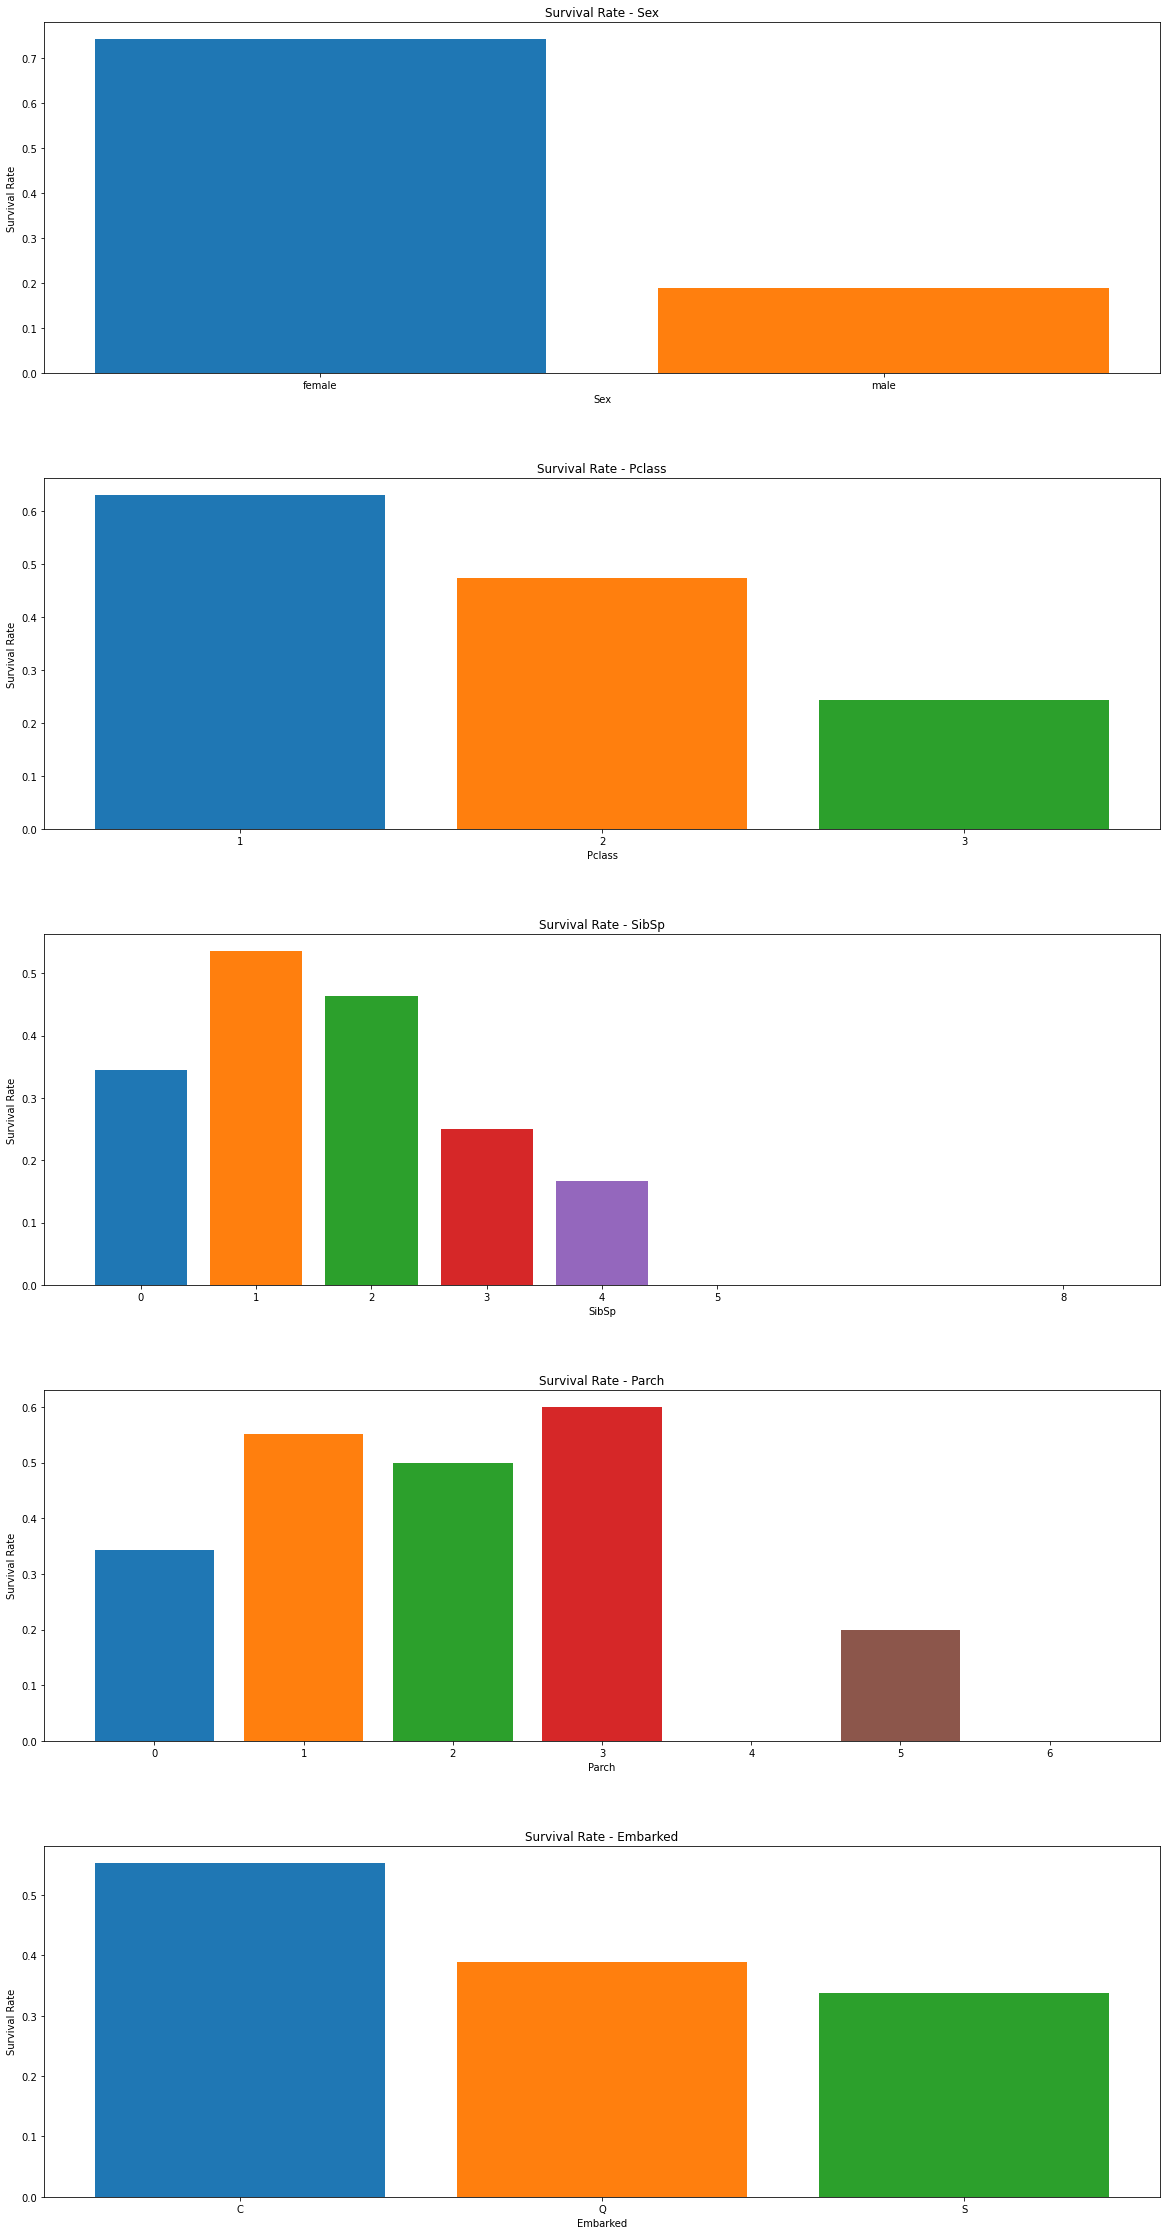

In [17]:
barplot_plt(df_plot, columns, 'Survival Rate', plot_ax=1, fig_unit_size=[20,8])

In [18]:
# # Count plot (Survived(1) / not survived (0))

# df_train = pd.read_csv('data/train.csv')
# fig, axes = plt.subplots(1,len(columns), figsize=(40, 8))
# plt.subplots_adjust(hspace=0.3)

# for column, ax in zip(columns, axes):
#     sns.countplot(x='Survived', hue=column, data=df_train, ax=ax)
#     ax.legend(loc='upper right')
#     ax.set_title(column)

In [19]:
# # Survival rate for each variable
# fig, axes = plt.subplots(1, len(columns), figsize=(40, 8))
# plt.subplots_adjust(hspace=0.3)

# for column, ax in zip(columns, axes):
#     sns.barplot(x=column, y='Survived', data=df_train, ax=ax, palette='Set1')
# plt.show()

**Findings from ProfileReport generated by pandas_profiling and Survival rate plots**
- Age, Fare (in test data), Embarked, Cabin have missing cells. --> Imputation is required

- Strong correlation between Pclass and Fare

- Survival rate of female is much higher than male  

- Survival rate of upper class (1) is the highest

- The embarked S is the highest number --> ** "S" is used for imputation in "Embarked" 
***

***
***
# Preprocessing
<a id="preprocess"></a>
***
***

## Data Imputation

***
***
**Cabin**  
~80% of Cabin data is missing --> discarded from the analysis at this stage

***
***
**Embarked**  
The embarked S is the most frequent --> **"S"** is used for imputation in "Embarked" 

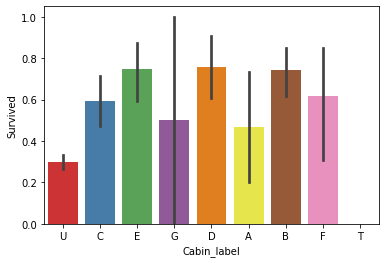

In [20]:
# Cabin
df_full['Cabin'] = df_full['Cabin'].fillna('Unknown')
df_full['Cabin_label']=df_full['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df_full, palette='Set1')
plt.show()

In [21]:
# Embarked
df_full["Embarked"] = df_full["Embarked"].fillna("S")

***
***
**Fare**  
Fare is correlated with Pclass and replace the missing values with median value of Fare in the same Pclass

In [22]:
# Passenger missing Fare value
df_full[df_full["Fare"].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_label
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,Unknown,S,U


In [23]:
# Fare
fare=df_full.loc[(df_full['Embarked'] == 'S'), 'Fare'].median()
df_full['Fare']=df_full['Fare'].fillna(fare)
# df_full[df_full["Fare"].isnull()]

***
***
**Age**  
Age has correlation with some values.
In this analysis, Age is estimated from Pclass, Sex, Parch, SibSo using **Random Forest**.   

In [24]:
# Select variables for estiamtion
age_df = df_full[['Age', 'Pclass', 'Sex', 'Parch', 'SibSp']]

# One-hot encoding 
age_df=pd.get_dummies(age_df)

# divide the data into training data and test data
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# from training data, create X, Y
X = known_age[:, 1:]  
y = known_age[:, 0]

# Build a model using Random Forest
rfr = RFR(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# Predict unkown age and impute missing data
predictedAges = rfr.predict(unknown_age[:, 1::])
df_full.loc[(df_full.Age.isnull()), 'Age'] = predictedAges 

df_full

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_label
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,Unknown,S,U
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,Unknown,S,U
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,C
4,5,0.0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,Unknown,S,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.421211,0,0,A.5. 3236,8.0500,Unknown,S,U
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.000000,0,0,PC 17758,108.9000,C105,C,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.500000,0,0,SOTON/O.Q. 3101262,7.2500,Unknown,S,U
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.421211,0,0,359309,8.0500,Unknown,S,U


**Visualise age distribution for survived/not survived group**

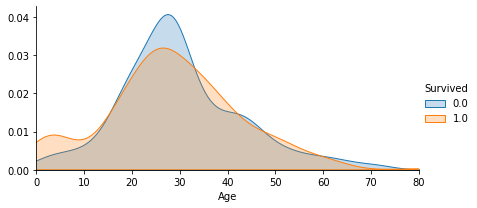

In [25]:
# Age distribution
facet = sns.FacetGrid(df_full[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_full.loc[:,'Age'].max()))
facet.add_legend()
plt.show()

***
***
## Feature Engineering
***
***

### Label ecoding

    - Age
    male: 0, female: 1  
      
    - Embarked
    Create one-hot data for each embarked place (Embarked -> Embarked_S, Embarked_Q, Embarked_C)

In [26]:
# ----------------- Label encodig -----------------
# labelEncoder = preprocessing.LabelEncoder()

# Sex
# df_full['Sex'] = df_full['Sex'].map({'male': 0, 'female': 1})

# Embarked
# Embarked_onehot = pd.get_dummies(df_full['Embarked'], prefix="Embarked")
# df_full = pd.concat((df_full, Embarked_onehot), axis=1)
# df_full.drop(['Embarked'], axis=1, inplace=True)
# df_full

***
***
### Create New Features
- FamilySize = SibSp + Parch + 1 

- FamilySurvived: Categorized FamilySize according to Survival rate 

- Title: Title exrtacted from name  

- Ticket label: Categorized Ticket according to survival rate

<AxesSubplot:xlabel='FamilySize', ylabel='Survived'>

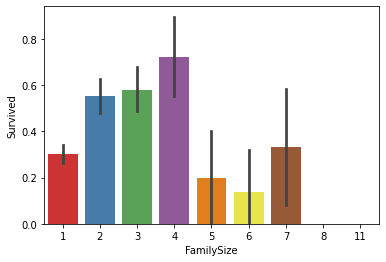

In [27]:
# ---- Family Size ---
df_full['FamilySize'] = df_full['SibSp'] + df_full['Parch'] + 1
df_plot = df_full[df_full['Survived'].notnull()]
# Survival rate
sns.barplot(x='FamilySize', y='Survived', data=df_plot, palette='Set1') 

In [28]:
# ---- Family Survival ----
#  Categorize FamilySize according to Survival rate 
# (high(FamilySize = 2-4): 2, low(FamilySize = 1, 5-7): 1, Zero (FamilySize>8): 0)
df_full.loc[(df_full['FamilySize']>=2) & (df_full['FamilySize']<=4), 'FamilySurvived'] = 2
df_full.loc[(df_full['FamilySize']>=5) & (df_full['FamilySize']<=7) | (df_full['FamilySize']==1), 'FamilySurvived'] = 1
df_full.loc[(df_full['FamilySize']>=8), 'FamilySurvived'] = 0

***
***
**Title extracted from name**

In [29]:
# ---- Name title ----
# Extract title from names
df_full['Title'] = df_full['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
pd.unique(df_full['Title'])

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer', 'Dona'], dtype=object)

<AxesSubplot:xlabel='Title', ylabel='Survived'>

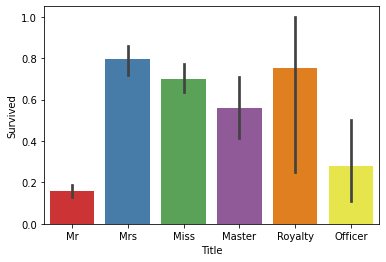

In [30]:
df_full['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_full['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_full['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_full['Title'].replace(['Mlle'], 'Miss', inplace=True)
df_full['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df_full, palette='Set1')

***
***
**Surname**  
The passengers who have the same surname are in the same family group and probably their survival rate can be correlated. Insights obtained from the analysis above indicated that females or children under 16 years had more chance to be survived compared to mele or over 16 years old. 

In [31]:
# ---- Surname ----
df_full['Surname'] = df_full['Name'].map(lambda name:name.split(', ')[0].strip())
df_full['FamilyGroup'] = df_full['Surname'].map(df_full['Surname'].value_counts())

# Survival rate of MALE and over 16 years old in the family
Male_Adult = df_full.loc[(df_full['FamilyGroup'] >= 2) & (df_full['Age'] > 16) & (df_full['Sex'] == 'male')] # Sex:0 = male
Male_Adult_list = Male_Adult.groupby('Surname')['Survived'].mean()
print('Survived groups (Male and Adult)')
print(Male_Adult_list.value_counts())

# Survival rate of FEMALE and under 16 years old in the family
Female_Child = df_full.loc[(df_full['FamilyGroup'] >= 2) & (df_full['Age'] <= 16) | (df_full['Sex'] == 'female')] # Sex:1 = female
Female_Child_list = Female_Child.groupby('Surname')['Survived'].mean()
print('Survived groups (Female or Child)')
print(Female_Child_list.value_counts())

Survived groups (Male and Adult)
0.000000    115
1.000000     21
0.500000      6
0.333333      2
0.250000      1
Name: Survived, dtype: int64
Survived groups (Female or Child)
1.000000    206
0.000000     55
0.750000      2
0.142857      1
0.500000      1
0.333333      1
Name: Survived, dtype: int64


***
**Key Findings**

The analysis above shows 115 groups of Male and Adult was not survived, but 21 passengers could be survived. At the same time, while the majority of groups of female and children were survived, some groups could not survived.  
Based on this insight, two lists are created:  
  
- Dead_list: list of surnames for groups that are of female and children but anyone could not be survived.  

- Survived_list: list of surnames of groups that are of male and adults but all could be survived.  
Base on these list, the information of the training set is replaced to typical information of survived/not survived passengers.  
  
**This method can simplify the estimation model**
***

In [32]:
# Create Dead list and Survived list
Dead_list=set(Female_Child_list[Female_Child_list.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_list[Male_Adult_list.apply(lambda x:x==1)].index)

print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# Based on dead/survived list, repalce Sex, Age, Title to typiocal data for each case 
df_full.loc[(df_full['Survived'].isnull()) & (df_full['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df_full.loc[(df_full['Survived'].isnull()) & (df_full['Surname'].apply(lambda x:x in Survived_list)),
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Jussila', 'Elias', 'Oreskovic', 'Palsson', 'Boulos', 'Haas', 'Funk', 'Henry', 'Turpin', 'Lahtinen', 'Dahlberg', 'Van Impe', 'Barbara', 'Caram', 'Bourke', 'Canavan', 'Vestrom', 'Danbom', 'Cacic', 'Panula', 'Hegarty', 'Johnston', 'Ilmakangas', 'Yrois', 'Sage', 'Goodwin', 'Robins', 'Zabour', 'Ford', 'Lindahl', 'Meanwell', 'Peters', 'Isham', 'Vander Planke', 'Attalah', 'Strandberg', 'Harknett', 'Olsson', 'Petranec', 'Skoog', 'Arnold-Franchi', 'Strom', 'Mack', 'Pettersson', "O'Sullivan", 'Meek', 'Laitinen', 'Lobb', 'Lindblom', 'Mangan', 'Rice', 'Rosblom', 'Lefebre', 'Heininen', 'Ahlin'}
Survived_list =  {'Frauenthal', 'Duff Gordon', 'Nakid', 'Beckwith', 'Goldenberg', 'Kimball', 'Daly', 'Frolicher-Stehli', 'Moubarek', 'McCoy', 'Greenfield', 'Jonsson', 'Bishop', 'Bradley', 'Chambers', 'Harder', 'Cardeza', 'Beane', 'Taylor', 'Dick', 'Jussila'}


***
***
**Ticket**  
The same Ticket number represents the passengers in the same room who may had the same destiny.

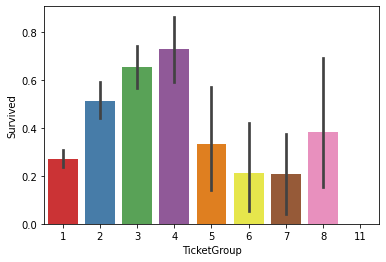

In [33]:
# Ticket
# Ticket group calculates the number of passengers who have the same ticket number
Ticket_Count = dict(df_full['Ticket'].value_counts())
df_full['TicketGroup'] = df_full['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df_full, palette='Set1')
plt.show()

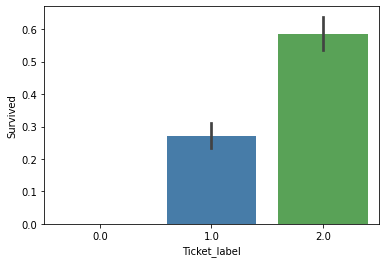

In [34]:
# Creates groups according to Survival Rate
df_full.loc[(df_full['TicketGroup']>=2) & (df_full['TicketGroup']<=4), 'Ticket_label'] = 2
df_full.loc[(df_full['TicketGroup']>=5) & (df_full['TicketGroup']<=8) | (df_full['TicketGroup']==1), 'Ticket_label'] = 1  
df_full.loc[(df_full['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df_full, palette='Set1')
plt.show()

## pre-processing

In [35]:
df_full.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Cabin_label',
       'FamilySize', 'FamilySurvived', 'Title', 'Surname', 'FamilyGroup',
       'TicketGroup', 'Ticket_label'],
      dtype='object')

In [36]:
df_original = df_full.copy()

In [37]:
# Select features used in estimation
df_full = df_original.copy()
df_full = df_full[['Survived', 'Embarked', 'Age', 'Fare','Pclass', 'Sex', 'Cabin_label', 'FamilySurvived', 'Title', 'Ticket_label']]

# One-hot encoding
df_full =pd.get_dummies(df_full)


# Split dataframe into train and test dataset
train = df_full[df_full['Survived'].notnull()]
test  = df_full[df_full['Survived'].isnull()].drop('Survived', axis=1) 

# Transform dataframe to numpy
X_train = train.drop('Survived', axis=1) # Feature variable
y_train = train['Survived'] # Survived label (0 or 1)
X_test = test

***
***
### Save the preprocessed data to CSV file

In [38]:
# Save preprocessed data
df_full.to_csv("data/data4model.csv", index=False)

***
***

# Model Development
<a id="modeldep"></a>
***

## Model Development / Model Tuning / Model Validation
<a id="developmodel"></a>
***
This section implement  Model Development / Model Tuning / Model Validation using the custom-made function ***model_deployer()***

In [39]:
train.columns

Index(['Survived', 'Age', 'Fare', 'Pclass', 'FamilySurvived', 'Ticket_label',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male',
       'Cabin_label_A', 'Cabin_label_B', 'Cabin_label_C', 'Cabin_label_D',
       'Cabin_label_E', 'Cabin_label_F', 'Cabin_label_G', 'Cabin_label_T',
       'Cabin_label_U', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty'],
      dtype='object')

In [40]:
# Paramerter settings
Seed = 10

# Linear Regression ------------------------------
linR = LinearRegression(n_jobs = -1)

# Logistic Regression ------------------------------
logR = LogisticRegression(n_jobs = -1)

# Extra Tree Classifier ------------------------------
etc = ETC(random_state=Seed
        , n_estimators=26
        , max_depth=8
        , min_samples_leaf=2
        , verbose=0
        )
# Random Forest Classifier ------------------------------
rfc = RFC(random_state = Seed
        , warm_start = True
        , n_estimators = 26
        , max_depth = 6
        , max_features = 'sqrt'
        )

n_estimators = [1, 5, 10, 20, 25, 50]
max_depth = [None, 5, 10, 20]
grid_rfc = {"n_estimators":n_estimators
            ,"max_depth": max_depth}

# Gradient Boosting ------------------------------
gbc = GBC(random_state=Seed
        , max_depth=5
        , min_samples_leaf=2
        , verbose=0
        ) 

#LightGBM ------------------------------
# XX_train,XX_test,yy_train,yy_test = train_test_split(X_train, y_train,test_size=0.2,random_state=0)
# lgb_train = lgb.Dataset(np.array(XX_train),np.array(yy_train))
# lgb_eval = lgb.Dataset(np.array(XX_test),np.array(yy_test),reference=lgb_train)
# params = {
#     'task': 'train',
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': {'l2'},
#     'num_leaves': 200,
#     'learning_rate': 0.003,
#     'num_iterations':100,
#     'feature_fraction': 0.52,
#     'bagging_fraction': 0.79,
#     'bagging_freq': 7,
#     'verbose': 0
# }

# lgb = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=5000,
#                 valid_sets=lgb_eval,
#                 early_stopping_rounds=1000)


# XGBoost
xgb = XGB(random_state=Seed
         ,eval_metric='logloss')

# Support Vector Classifier ------------------------------
# Linear
linsvc = LinearSVC(C=0.025
        )
grid_linsvc = {'C': [0.001, 0.01, 0.1, 1, 10]}
#poly or rbf
svc = SVC()
grid_svc = {'kernel':['poly','rbf']
    ,'C': [1, 10, 100, 1000, 10000]}

# Generate a dictionary of models
clfs = {#'linear_regression': linR
         'logistic_regression': logR
        , 'extra_trees': etc
        , 'random_forest': rfc
        , 'gradient_boosting': gbc
        , 'xgboost':xgb
        , 'linear_support_vector':linsvc
        , 'support_vector': svc
        # ,'xgboost': XGBClassifier(random_state=0)
        # ,'ada_boost': AdaBoostClassifier(random_state=0)
}

grid_params = {'linear_regression': None
        , 'logistic_regression': None
        , 'extra_trees': None
        , 'random_forest': grid_rfc
        , 'gradient_boosting': None
        , 'xgboost':None
        , 'linear_support_vector': grid_linsvc
        , 'support_vector': grid_svc
              }

In [41]:
results_model = model_deployer(clfs, X_train, y_train, X_test,
                              gs_params = grid_params, select_num = 20, cv=10)

logistic_regression(with SelectKBest (k=20))
Mean Score:0.8059
Mean std:0.0347
----------------------------------
extra_trees(with SelectKBest (k=20))
Mean Score:0.8373
Mean std:0.0399
----------------------------------
random_forest(with SelectKBest (k=20) and GridSearchCV)
Best Score:0.8373
Best Prameters: {'random_forest__max_depth': 5, 'random_forest__n_estimators': 20}
----------------------------------
gradient_boosting(with SelectKBest (k=20))
Mean Score:0.8384
Mean std:0.0469
----------------------------------
xgboost(with SelectKBest (k=20))
Mean Score:0.8272
Mean std:0.0484
----------------------------------
linear_support_vector(with SelectKBest (k=20) and GridSearchCV)
Best Score:0.8092
Best Prameters: {'linear_support_vector__C': 0.01}
----------------------------------
support_vector(with SelectKBest (k=20) and GridSearchCV)
Best Score:0.8238
Best Prameters: {'support_vector__C': 1000, 'support_vector__kernel': 'rbf'}
----------------------------------


**Linear Regression**

In [42]:
# prepare for the cross-validation data
Xx_train, Xx_test, yy_train, yy_test = train_test_split(X_train, y_train, test_size=0.4, random_state=42)

# Linear Regression Model
linR.fit(Xx_train, yy_train)

# predict for corss-validation
predict_cv = np.where(linR.predict(Xx_test) > 0.5, 1, 0)

# Cross-validation score
score_linR = accuracy_score(yy_test, predict_cv)

print('linear_regression')
print('Score: ' + str(score_linR))
print('----------------------------------')

linear_regression
Score: 0.7927170868347339
----------------------------------


In [43]:
linR.fit(X_train, y_train)
# Add the result of linear regression to the results_model
results_model['linear_regression'] = {'score': score_linR
                                , 'feature_name': X_train.columns
                                , 'estimator': linR
                                , 'feature_importances':None
                                , 'prediction': np.where(linR.predict(X_test) > 0.5, 1, 0)
                                }

***
**Score**
***

In [44]:
df_score = pd.DataFrame.from_dict({(i): results_model[i]['score'] 
                           for i in results_model.keys() 
#                            for j in results_model[i].keys()
                                   },
                       orient='index').reset_index()
df_score.columns = ['Models', 'Score']
df_score

,Models,Score
0,logistic_regression,0.805905
1,extra_trees,0.837278
2,random_forest,0.837266
3,gradient_boosting,0.838439
4,xgboost,0.827179
5,linear_support_vector,0.809189
6,support_vector,0.823783
7,linear_regression,0.792717


***
**Feature Importance**
***

In [45]:
df_feature = pd.DataFrame.from_dict({(i): results_model[i]['feature_importances'] 
                           for i in results_model.keys()}
                        ).rename(index=pd.DataFrame(results_model[next(iter(results_model))]['feature_name'])[0])
df_feature
# df_feature.rename(index = df_name)

,logistic_regression,extra_trees,random_forest,gradient_boosting,xgboost,linear_support_vector,support_vector,linear_regression
Age,None,0.034451,0.057934,0.185541,0.016465,None,None,None
Fare,None,0.032544,0.108202,0.242129,0.019229,None,None,None
Pclass,None,0.083941,0.118889,0.093501,0.089464,None,None,None
FamilySurvived,None,0.037058,0.022894,0.008105,0.013199,None,None,None
Ticket_label,None,0.055028,0.059325,0.016018,0.031525,None,None,None
Embarked_C,None,0.018348,0.010908,0.004924,0.011280,None,None,None
Embarked_S,None,0.018264,0.009082,0.008202,0.012646,None,None,None
Sex_female,None,0.125042,0.142231,0.019429,0.034027,None,None,None
Sex_male,None,0.185756,0.187387,0.012725,0.000000,None,None,None
Cabin_label_B,None,0.007652,0.002882,0.002884,0.019644,None,None,None


<AxesSubplot:xlabel='features'>

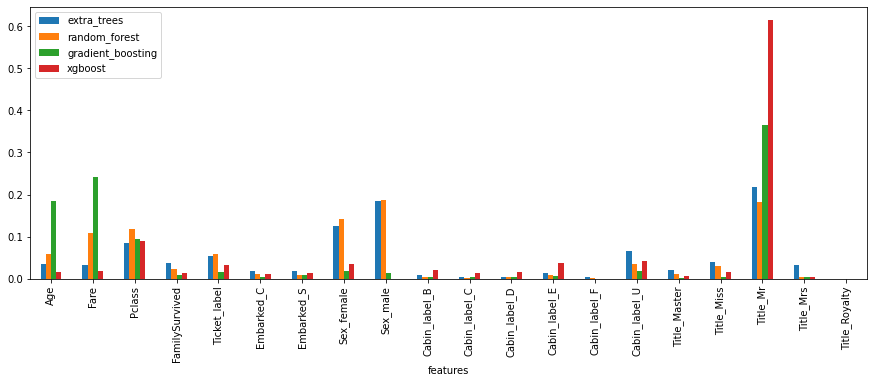

In [46]:
df_feature_plot = df_feature.copy().reset_index()
df_feature_plot = df_feature_plot.rename(columns={'index':'features'})
df_feature_plot = df_feature_plot.drop(['logistic_regression', 'support_vector', 'linear_support_vector'], axis=1)
df_feature_plot.plot.bar(x='features', figsize=(15,5))

### Neural Network / Deep Learning
<a id="deeplearning"></a>
***

**Keras**   
Please see the separate notebook for the neural network model built by Keras.  
(TitanicSurvivalPrediction_NNmodel_Keras.ipynb)  

# Deploy
<a id="deploy"></a>

In [ ]:
def save_csv(df_id, results, res_label, save_filename_head='prediction', res_dir='results'):
    """ Save prediction results 

    """
    for key in results.keys():
        df_prediction = pd.DataFrame({res_label: results[key]['prediction'],})

        df_out = pd.concat(df_id, df_prediction)

        df_out.to_csv(res_dir + '/' + save_filename_head + '-' + key + '.csv', index=False)

In [73]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,NaN
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,NaN
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,NaN
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,NaN


In [76]:
key = 'random_forest'
df_id = df_test[['PassengerId']]
prediction = results_model[key]['prediction']
# df_out = pd.DataFrame({"PassengerId": df_id, "Survived": prediction.astype(np.int32)})
df_out = df_id.join(pd.DataFrame({"Survived": prediction.astype(np.int32)}))
df_out.to_csv('results')

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [47]:
BestModel = 'random_forest'
BestPrediction = predictions[BestModel]
PassengerId = df_test['PassengerId']
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": BestPrediction.astype(np.int32)})
submission.to_csv("results/Titianic_RDF_model.csv", index=False)

NameError: name 'predictions' is not defined

# Appendix
<a id="Append"></a>

## A1. Examples of output from functions

### *grouped_data_summary()*

In [ ]:
# Dataframe
df_cp = df_train.copy()
# Parameters
group_by = ['Sex', 'Pclass']
group_key = ['Survived']
agg_functions=['sum', 'mean']
column_names = ['Counts', 'Percentage']
# Get new dataframe in a dictionary
df_summary = grouped_data_summary(df_cp, group_by, group_key, agg_functions, column_names)

In [ ]:
df_summary['Sex']

In [ ]:
df_summary['Pclass']

In [ ]:
barplot_plt(df_summary, 'Sex', 'Percentage', plot_ax=1)

In [ ]:
barplot_sns(df_summary, ['Sex', "Pclass"], 'Counts', plot_ax=1)